### MP: Leave-one-out-Labels

* The following notebook is trained on data generated from revised R script [Oct 12 2017]
    * Exact Match [1] and Homozygous [0] Reference data points
    * Removed all data points with Gtcons and GTconswithoutXX -1
* 5k randomly selected deletions test data was also processed through same R script
* Balanced Training Set for GTconswithoutXX labels:
    * 200 Hom Var
    * 200 Hom Ref
    * 200 Het Var
* **Train/Prediction Label:** GTconswithoutXX


In [1]:
"""
Imports
"""
import pandas as pd
import numpy as np
from fancyimpute import KNN
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import LeaveOneOut
from scipy.stats import ks_2samp
from scipy import stats
from matplotlib import pyplot
from sklearn import preprocessing
from scipy.linalg import svd
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA as sklearnPCA
import plotly.plotly as py
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import f1_score, precision_score
from sklearn import preprocessing
from ggplot import *
from bokeh.charts import TimeSeries
from bokeh.models import HoverTool
from bokeh.plotting import show
from bokeh.charts import Scatter, Histogram, output_file, show
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.io import output_notebook
from bokeh.charts import Bar, output_file, show
import bokeh.palettes as palettes
from bokeh.models import HoverTool, BoxSelectTool, Legend
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.



In [2]:
# Import Training Data
# SVanalyzer generated training data
df_train = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/dataframes/training_data/tech_sep/HG002/DEL/MP_EM_HR_HG002_DEL_balanced_label_LOO_min1.csv')
df_train_2 = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/dataframes/training_data/tech_sep/HG002/DEL/MP_EM_HR_HG002_DEL_balanced_label_LOO_min1.csv')
df_train.rename(columns={'size': 'Size'}, inplace=True)
df_train.head(1)

,chrom,sample,id,start,end,Size,type,SVtype,refN_cnt,refN_pct,...,IllMP.amb_reason_orientation_orientation,IllMP.amb_reason_same_scores,IllMP.ref_alnScore_mean,IllMP.ref_alnScore_std,IllMP.ref_count,IllMP.ref_insertSize_mean,IllMP.ref_insertSize_std,IllMP.ref_reason_alignmentScore,IllMP.ref_reason_insertSizeScore,IllMP.ref_reason_orientation
0,1,HG002,21,65326531,65326651,-120,Deletion,Deletion,0,0,...,35.0,336.0,418.75,63.408234,24.0,6629.333333,928.603551,24.0,0.0,0.0


In [3]:
train_set = pd.DataFrame()
train_set = df_train_2

In [4]:
train_set['GTcons'].replace(0, 'Homozygous_Reference', inplace=True)
train_set['GTcons'].replace(1, 'Heterozygous_Variant', inplace=True)
train_set['GTcons'].replace(2, 'Homozygous_Variant', inplace=True)

<a id='imbalance'></a>

In [5]:
pd.value_counts(train_set['GTconswithoutIllMP.GT'].values, sort=False)

0    200
1    200
2    200
dtype: int64

In [6]:
# Train the model only on the rows that have an Exact Match or Homozygous Reference Label
# This step removes any row that has in 'Inaccurate Call' label
df_train = df_train[(df_train['Label'] == 1) | (df_train['Label'] == 0)]
df_train_2 = df_train_2[(df_train_2['Label'] == 1) | (df_train_2['Label'] == 0)]

In [7]:
# There are only Exact Match [1] and Homozygous Reference Labels [0]
pd.value_counts(df_train['Label'].values, sort=False)

0    164
1    436
dtype: int64

<a id='hom_ref'></a>

In [8]:
# Import Test Data
# SVanalyzer generated training data
df_test = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/dataframes/test/final_df/tech_sep/DEL/HG002/MP_HG002_DEL_min1.csv')
df_test_2 = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/dataframes/test/final_df/tech_sep/DEL/HG002/MP_HG002_DEL_min1.csv')
df_test.rename(columns={'size': 'Size'}, inplace=True)
df_test.head(1)

,chrom,sample,id,start,end,Size,type,SVtype,refN_cnt,refN_pct,...,IllMP.amb_reason_orientation_orientation,IllMP.amb_reason_same_scores,IllMP.ref_alnScore_mean,IllMP.ref_alnScore_std,IllMP.ref_count,IllMP.ref_insertSize_mean,IllMP.ref_insertSize_std,IllMP.ref_reason_alignmentScore,IllMP.ref_reason_insertSizeScore,IllMP.ref_reason_orientation
0,1,HG002,859,37568322,37568587,-115,Insertion,Deletion,0,0,...,43.0,456.0,411.08,53.348604,25.0,6586.56,999.928961,15.0,0.0,10.0


In [9]:
# Store header names in lists and find names that are NOT contained in BOTH lists
c = list(df_train.columns.values)
d = list(df_test.columns.values)
set(c) - set(d)

{'Label'}

In [10]:
### Drop columns that are not shared by both dataframes
df_train.drop(['Label'], axis=1, inplace = True)
df_train.drop(['GTcons'], axis=1, inplace = True)
df_train.drop(['GTconflict'], axis=1, inplace = True)
df_train.drop(['GTsupp'], axis=1, inplace = True)
df_train.drop(['sample'], axis=1, inplace = True)
df_train.drop(['SVtype'], axis=1, inplace = True)
df_train.drop(['type'], axis=1, inplace = True)
df_train.drop(['id'], axis=1, inplace = True)

In [11]:
df_train.head(1)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,IllMP.amb_reason_orientation_orientation,IllMP.amb_reason_same_scores,IllMP.ref_alnScore_mean,IllMP.ref_alnScore_std,IllMP.ref_count,IllMP.ref_insertSize_mean,IllMP.ref_insertSize_std,IllMP.ref_reason_alignmentScore,IllMP.ref_reason_insertSizeScore,IllMP.ref_reason_orientation
0,1,65326531,65326651,-120,0,0,0,0.0,1,1.0,...,35.0,336.0,418.75,63.408234,24.0,6629.333333,928.603551,24.0,0.0,0.0


In [12]:
df_train['chrom'].replace('X', 23, inplace=True)
df_train['chrom'].replace('Y', 24, inplace=True)
df_test['chrom'].replace('X', 23, inplace=True)
df_test['chrom'].replace('Y', 24, inplace=True)

In [13]:
# Store header names in lists and find names that are NOT contained in BOTH lists
c = list(df_train.columns.values)
d = list(df_test.columns.values)
set(d) - set(c)

{'GTconflict',
 'GTcons',
 'GTsupp',
 'IllMP.amb_reason_orientation_insertSizeScore',
 'SVtype',
 'id',
 'sample',
 'type'}

In [14]:
### Drop columns that are not shared by both dataframes
df_test.drop(['IllMP.amb_reason_orientation_insertSizeScore'], axis=1, inplace = True)
df_test.drop(['GTconswithoutIllMP.GT'], axis=1, inplace = True)
df_test.drop(['GTcons'], axis=1, inplace = True)
df_test.drop(['GTconflict'], axis=1, inplace = True)
df_test.drop(['GTsupp'], axis=1, inplace = True)
df_test.drop(['sample'], axis=1, inplace = True)
df_test.drop(['SVtype'], axis=1, inplace = True)
df_test.drop(['type'], axis=1, inplace = True)
df_test.drop(['id'], axis=1, inplace = True)

***
Impute missing values using KNN
***

In [15]:
# Store training data in a new variable which will be converted to a matrix
X = df_train
X.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,IllMP.amb_reason_orientation_orientation,IllMP.amb_reason_same_scores,IllMP.ref_alnScore_mean,IllMP.ref_alnScore_std,IllMP.ref_count,IllMP.ref_insertSize_mean,IllMP.ref_insertSize_std,IllMP.ref_reason_alignmentScore,IllMP.ref_reason_insertSizeScore,IllMP.ref_reason_orientation
0,1,65326531,65326651,-120,0,0,0,0.0,1,1.0,...,35.0,336.0,418.750000,63.408234,24.0,6629.333333,928.603551,24.0,0.0,0.0
1,1,83753489,83753698,-209,0,0,1,1.0,1,1.0,...,13.0,242.0,418.764706,63.896543,17.0,7069.176471,952.851216,17.0,0.0,0.0
2,1,152326749,152326980,-231,0,0,1,1.0,0,0.0,...,33.0,273.0,421.454545,66.396007,22.0,6880.363636,750.663194,22.0,0.0,0.0


In [16]:
# Convert dataframe to matrix
X=X.as_matrix()

#Imput missing values from three closest observations
X_imputed=KNN(k=3).complete(X)
X=pd.DataFrame(X_imputed)

Imputing row 1/600 with 0 missing, elapsed time: 0.125
Imputing row 101/600 with 0 missing, elapsed time: 0.126
Imputing row 201/600 with 0 missing, elapsed time: 0.127
Imputing row 301/600 with 0 missing, elapsed time: 0.127
Imputing row 401/600 with 0 missing, elapsed time: 0.128
Imputing row 501/600 with 0 missing, elapsed time: 0.129


In [17]:
# Store header values in a list, will be used later to re-label the matrix post KNN imputation
dftrain_header = list(df_train.columns.values)
X.columns = dftrain_header
X.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,IllMP.amb_reason_orientation_orientation,IllMP.amb_reason_same_scores,IllMP.ref_alnScore_mean,IllMP.ref_alnScore_std,IllMP.ref_count,IllMP.ref_insertSize_mean,IllMP.ref_insertSize_std,IllMP.ref_reason_alignmentScore,IllMP.ref_reason_insertSizeScore,IllMP.ref_reason_orientation
0,1.0,65326531.0,65326651.0,-120.0,0.0,0.0,0.0,0.0,1.0,1.0,...,35.0,336.0,418.750000,63.408234,24.0,6629.333333,928.603551,24.0,0.0,0.0
1,1.0,83753489.0,83753698.0,-209.0,0.0,0.0,1.0,1.0,1.0,1.0,...,13.0,242.0,418.764706,63.896543,17.0,7069.176471,952.851216,17.0,0.0,0.0
2,1.0,152326749.0,152326980.0,-231.0,0.0,0.0,1.0,1.0,0.0,0.0,...,33.0,273.0,421.454545,66.396007,22.0,6880.363636,750.663194,22.0,0.0,0.0


In [19]:
# Store Labels in a new 'Y' DataFrame
Y = pd.DataFrame()
Y = X['GTconswithoutIllMP.GT']

In [20]:
#Count the number of labels
pd.value_counts(Y.values, sort=False)

0.0    200
1.0    200
2.0    200
dtype: int64

In [21]:
# Remove labels from feature set
X.drop(['GTconswithoutIllMP.GT'],axis=1, inplace = True)

In [22]:
# Order features
X4 = X.reindex_axis(sorted(X.columns), axis=1)

***
Machine Learning
***

<a id='machine_learning'></a>

Description:

   * In the following section a random forest model will be trained on svanalyzer data.

       * The model was trained using [train/test split](http://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.train_test_split.html) where 70% of the data was used to train the model and the model performance was determined by predicting labels for the remaining 30% of the data. The trained model will be used in a [later section](#predict) to predict the consensus GT for 5000 randomly selected deletions [these deletions were randomly selected from [union_170509_refalt.sort.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/)]
       * In the following section, svanalyzer data was used to train a random forest (RF) model. The features for the svanalyzer dataset include: svviz features, GA4GH features [RefN, Segmental Duplications, Tandem Repeat], preliminary R script analysis [consensus GT, GTsup].
       * The RF classifier will predict the consensus GT labels:
           * Homozygous Reference (0)
           * Heterozygous Variant (1)
           * Homozygous Variant (2)
       
       * In the [following section](#prediction_step), the trained RF model will be used to predict labels for genotype labels for 5000 randomly selected deletions [these deletions were randomly selected from [union_170509_refalt.sort.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/)]. 

** Train Random Forest Classifier **

<a id='train_test'></a>

In [23]:
# Train Test Split
# Train on 70% of the data and test on 30%
X_train, X_test, y_train, y_test = train_test_split(X4, Y, test_size=0.3, random_state=0)

In [24]:
# %%timeit
# Train Random Forest Classifier
model = RandomForestClassifier() 
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [ ]:
# Feature Importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X_test.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

[Another Resource](https://stackoverflow.com/questions/37877542/how-to-label-the-feature-importance-with-forests-of-trees)

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning:

sort is deprecated, use sort_values(inplace=True) for INPLACE sorting



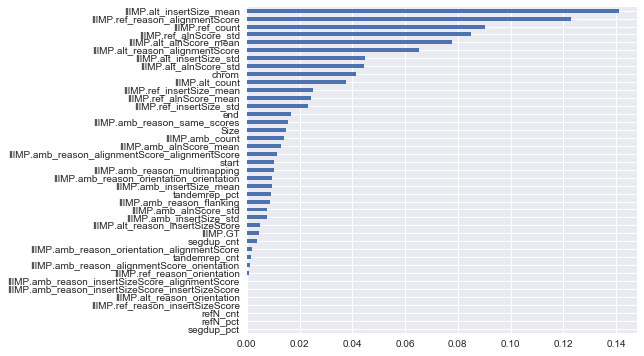

In [26]:
%matplotlib inline
feature_importances = pd.Series(model.feature_importances_, index=X_test.columns)
feature_importances.sort()
feature_importances.plot(kind="barh", figsize=(7,6))

In [ ]:
#TODO: Try training the model with the most important features and note difference in overal model prediction score

In [27]:
#NOTE: Training Set - Show number of Hom Ref, Hom Var, Het Var datapoints the model was trained on
ytrain = pd.DataFrame()
ytrain['ytrain'] = y_train
pd.value_counts(ytrain['ytrain'].values, sort=False)

1.0    139
2.0    136
0.0    145
dtype: int64

<a id='prediction_step'></a>

In [28]:
pred = model.predict(X_test)

<a id='low_precision'></a>

In [29]:
print('Precision score of the training subset: {:.3f}'.format(precision_score(pred, y_test, average='micro'))) 

Precision score of the training subset: 0.861


In [30]:
# Add original labels and predicted labels back to the original dataframe
df_Xtest = pd.DataFrame(X_test)
df_Xtest.head()

,IllMP.GT,IllMP.alt_alnScore_mean,IllMP.alt_alnScore_std,IllMP.alt_count,IllMP.alt_insertSize_mean,IllMP.alt_insertSize_std,IllMP.alt_reason_alignmentScore,IllMP.alt_reason_insertSizeScore,IllMP.alt_reason_orientation,IllMP.amb_alnScore_mean,...,Size,chrom,end,refN_cnt,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct
434,-1.0,340.333333,36.160138,3.0,6190.000000,199.514410,3.0,0.0,0.0,357.834262,...,-36.0,11.0,67518800.0,0.0,0.0,1.0,1.0,67518763.0,1.0,1.000000
122,-1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,362.062248,...,-94.0,10.0,88840783.0,0.0,0.0,0.0,0.0,88840689.0,1.0,1.000000
224,-1.0,429.250000,45.212692,4.0,6745.500000,352.179287,4.0,0.0,0.0,355.472159,...,-26.0,1.0,165220279.0,0.0,0.0,0.0,0.0,165220252.0,0.0,0.000000
479,-1.0,418.500000,80.095256,4.0,7077.250000,1248.984262,4.0,0.0,0.0,353.497413,...,-27.0,19.0,51460422.0,0.0,0.0,0.0,0.0,51460394.0,1.0,1.000000
205,-1.0,472.666667,30.868898,9.0,5309.555556,1753.311477,9.0,0.0,0.0,357.249671,...,-27.0,1.0,5928819.0,0.0,0.0,0.0,0.0,5928792.0,1.0,0.518519


In [31]:
labels = pd.DataFrame(y_test)

In [33]:
df_Xtest['predicted_label'] = pred
df_Xtest['GTconswithoutIllMP.GT'] = df_train['GTconswithoutIllMP.GT']
df_Xtest['chrom'] = df_train['chrom']
df_Xtest['start'] = df_train['start']
df_Xtest['end'] = df_train['end']
# df_Xtest['Y_test'] = labels

In [34]:
df_Xtest['GTconswithoutIllMP.GT'].replace(0.0, 'Homozygous_Reference', inplace=True)
df_Xtest['GTconswithoutIllMP.GT'].replace(1.0, 'Heterozygous_Variant', inplace=True)
df_Xtest['GTconswithoutIllMP.GT'].replace(2.0, 'Homozygous_Variant', inplace=True)
df_Xtest['predicted_label'].replace(0.0, 'Homozygous_Reference', inplace=True)
df_Xtest['predicted_label'].replace(1.0, 'Heterozygous_Variant', inplace=True)
df_Xtest['predicted_label'].replace(2.0, 'Homozygous_Variant', inplace=True)

In [35]:
pd.value_counts(df_Xtest['GTconswithoutIllMP.GT'].values, sort=False)

Homozygous_Reference    55
Heterozygous_Variant    61
Homozygous_Variant      64
dtype: int64

In [36]:
pd.value_counts(df_Xtest['predicted_label'].values, sort=False)

Homozygous_Reference    60
Heterozygous_Variant    56
Homozygous_Variant      64
dtype: int64

In [37]:
from sklearn.metrics import confusion_matrix
ytest = df_Xtest['GTconswithoutIllMP.GT']
predict = df_Xtest['predicted_label']
print(confusion_matrix(ytest, predict))

[[47  6  8]
 [ 3 52  0]
 [ 6  2 56]]


In [38]:
pd.crosstab(ytest, predict, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Heterozygous_Variant,Homozygous_Reference,Homozygous_Variant,All
True,,,,
Heterozygous_Variant,47,6,8,61
Homozygous_Reference,3,52,0,55
Homozygous_Variant,6,2,56,64
All,56,60,64,180


In [39]:
from sklearn.metrics import classification_report
print(classification_report(ytest, predict))

                      precision    recall  f1-score   support

Heterozygous_Variant       0.84      0.77      0.80        61
Homozygous_Reference       0.87      0.95      0.90        55
  Homozygous_Variant       0.88      0.88      0.88        64

         avg / total       0.86      0.86      0.86       180



***
Predict
***

<a id='predict'></a>

Description:

   * In the [previous section](#machine_learning), a RF model was trained on svanalyzer data.

       * The model was trained using [train/test split](#train_test) where 70% of the data was used to train the model and the model performance was determined by predicting labels for the remaining 30% of the data
 * Reminder: The labels for this training set and the following [prediction step](#prediction_step) are the consensus genotype (GTcons) labels generated from a preliminary R analysis based on reference and alternate read count:
           * Homozygous Reference (0)
           * Heterozygous Variant (1)
           * Homozygous Variant (2)
           
   * The trained model is used in the following section to predict labels for 5000 randomly selected Deletions [these datapoints were randomly selected from [union_170509_refalt.sort.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/)]
   
   

** Load Data **

In [40]:
X2 = df_test

** Impute missing values using KNN **

In [41]:
#Convert dataframe to matrix
X2=X2.as_matrix()
X2=pd.DataFrame(X2)

# Imput missing values from three closest observations
X2_imputed=KNN(k=3).complete(X2)
X2=pd.DataFrame(X2_imputed)

Imputing row 1/4030 with 1 missing, elapsed time: 5.165
Imputing row 101/4030 with 1 missing, elapsed time: 5.171
Imputing row 201/4030 with 1 missing, elapsed time: 5.177
Imputing row 301/4030 with 1 missing, elapsed time: 5.183
Imputing row 401/4030 with 1 missing, elapsed time: 5.189
Imputing row 501/4030 with 1 missing, elapsed time: 5.195
Imputing row 601/4030 with 1 missing, elapsed time: 5.203
Imputing row 701/4030 with 1 missing, elapsed time: 5.209
Imputing row 801/4030 with 1 missing, elapsed time: 5.218
Imputing row 901/4030 with 1 missing, elapsed time: 5.223
Imputing row 1001/4030 with 1 missing, elapsed time: 5.229
Imputing row 1101/4030 with 1 missing, elapsed time: 5.235
Imputing row 1201/4030 with 1 missing, elapsed time: 5.240
Imputing row 1301/4030 with 1 missing, elapsed time: 5.246
Imputing row 1401/4030 with 1 missing, elapsed time: 5.251
Imputing row 1501/4030 with 1 missing, elapsed time: 5.258
Imputing row 1601/4030 with 1 missing, elapsed time: 5.269
Imputing 

In [42]:
dftest_header = list(df_test.columns.values)
X2.columns = dftest_header
X2.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,IllMP.amb_reason_orientation_orientation,IllMP.amb_reason_same_scores,IllMP.ref_alnScore_mean,IllMP.ref_alnScore_std,IllMP.ref_count,IllMP.ref_insertSize_mean,IllMP.ref_insertSize_std,IllMP.ref_reason_alignmentScore,IllMP.ref_reason_insertSizeScore,IllMP.ref_reason_orientation
0,1.0,37568322.0,37568587.0,-115.0,0.0,0.0,0.0,0.0,3.0,0.818868,...,43.0,456.0,411.080000,53.348604,25.0,6586.560000,999.928961,15.0,0.0,10.0
1,1.0,1092675.0,1092715.0,-40.0,0.0,0.0,0.0,0.0,1.0,1.000000,...,34.0,345.0,370.000000,0.000000,1.0,4426.000000,0.000000,1.0,0.0,0.0
2,1.0,2629212.0,2629373.0,-160.0,0.0,0.0,1.0,1.0,0.0,0.000000,...,104.0,111.0,392.192308,77.179620,26.0,5318.038462,2166.320853,25.0,0.0,1.0


In [43]:
X3 = pd.DataFrame()
X3 = X2
X3.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,IllMP.amb_reason_orientation_orientation,IllMP.amb_reason_same_scores,IllMP.ref_alnScore_mean,IllMP.ref_alnScore_std,IllMP.ref_count,IllMP.ref_insertSize_mean,IllMP.ref_insertSize_std,IllMP.ref_reason_alignmentScore,IllMP.ref_reason_insertSizeScore,IllMP.ref_reason_orientation
0,1.0,37568322.0,37568587.0,-115.0,0.0,0.0,0.0,0.0,3.0,0.818868,...,43.0,456.0,411.080000,53.348604,25.0,6586.560000,999.928961,15.0,0.0,10.0
1,1.0,1092675.0,1092715.0,-40.0,0.0,0.0,0.0,0.0,1.0,1.000000,...,34.0,345.0,370.000000,0.000000,1.0,4426.000000,0.000000,1.0,0.0,0.0
2,1.0,2629212.0,2629373.0,-160.0,0.0,0.0,1.0,1.0,0.0,0.000000,...,104.0,111.0,392.192308,77.179620,26.0,5318.038462,2166.320853,25.0,0.0,1.0


In [44]:
# Order features
X5 = X2.reindex_axis(sorted(X2.columns), axis=1)

In [45]:

# X5 = df_test

<a id='prediction_step'></a>

In [46]:
pred = model.predict(X5)

In [47]:
pred_prob = model.predict_proba(X5)

In [48]:
pred_prob_log = model.predict_log_proba(X5)

In [49]:
X5['predicted_label'] = pred
X5['chrom'] = df_test_2['chrom']
X5['GTcons'] = df_test_2['GTcons']
X5['start'] = df_test_2['start']
X5['end'] = df_test_2['end']
X5['Size'] = df_test_2['Size']
X5['GTconswithoutIllMP.GT'] = df_test_2['GTconswithoutIllMP.GT']
X5['GTsupp'] = df_test_2['GTsupp']

In [50]:
X6 = pd.concat([X5, pd.DataFrame(pred_prob, columns=['1','2','3'])])

In [51]:
X7 = pd.concat([X5, pd.DataFrame(pred_prob_log, columns=['1','2','3'])])

In [52]:
X6.to_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/summary_plots/data/preliminary_df/MP_pred_prob_DEL_revisedR_LOO.csv', index=False)

In [53]:
X7.to_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/summary_plots/data/preliminary_df/MP_pred_prob_log_DEL_revisedR_LOO.csv', index=False)

In [ ]:
#Note: Reformat X6 csv

In [54]:
X6 = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/summary_plots/data/preliminary_df/MP_pred_prob_DEL_revisedR_LOO.csv')

In [55]:
X6.rename(columns={'1': 'Homozygous_Reference_LOO_MP'}, inplace=True)
X6.rename(columns={'2': 'Heterozygous_Variant_LOO_MP'}, inplace=True)
X6.rename(columns={'3': 'Homozygous_Variant_LOO_MP'}, inplace=True)
X6.rename(columns={'predicted_label': 'MP_predicted_LOO_label'}, inplace=True)

In [56]:
X6.head(3)

,Homozygous_Reference_LOO_MP,Heterozygous_Variant_LOO_MP,Homozygous_Variant_LOO_MP,GTcons,GTconswithoutIllMP.GT,GTsupp,IllMP.GT,IllMP.alt_alnScore_mean,IllMP.alt_alnScore_std,IllMP.alt_count,...,chrom,end,MP_predicted_LOO_label,refN_cnt,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct
0,1.0,0.0,0.0,0,0,4,-1.0,0.0,0.0,0.0,...,1,37568587,0,0,0,0,0.0,37568322,3,0.818868
1,0.2,0.1,0.7,1,1,1,-1.0,488.0,0.0,1.0,...,1,1092715,2,0,0,0,0.0,1092675,1,1.000000
2,0.3,0.7,0.0,0,0,1,-1.0,472.0,0.0,1.0,...,1,2629373,1,0,0,1,1.0,2629212,0,0.000000


In [57]:
X6.to_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/summary_plots/data/MP_final_GTcons_LOO_DEL_SVanalyzer.csv', index=False)

***
Label Analysis
***

Description:
  * The [random forest(RF) model](#train_test) was trained on svanalyzer data. The trained model was used to predict consensus GT labels for the 5000 deletions that were randomly selected from the union_refalt vcf. The following is a comparison of model predicted labels [Conesus GT] to consensus genotype generated by the R script for the 5000 randomly selected datapoints from union_refalt.vcf 

In [60]:
from sklearn.metrics import confusion_matrix
consensus_GT = X6['GTconswithoutIllMP.GT']
predict = X6['MP_predicted_LOO_label']
print(confusion_matrix(consensus_GT, predict))

[[ 712  120   47]
 [ 262 1546  432]
 [  12   78  821]]


In [61]:
X6['GTconswithoutIllMP.GT'].replace(0, 'Homozygous_Reference', inplace=True)
X6['GTconswithoutIllMP.GT'].replace(1, 'Heterozygous_Variant', inplace=True)
X6['GTconswithoutIllMP.GT'].replace(2, 'Homozygous_Variant', inplace=True)
X6['MP_predicted_LOO_label'].replace(0.0, 'Homozygous_Reference', inplace=True)
X6['MP_predicted_LOO_label'].replace(1.0, 'Heterozygous_Variant', inplace=True)
X6['MP_predicted_LOO_label'].replace(2.0, 'Homozygous_Variant', inplace=True)

In [62]:
pd.crosstab(consensus_GT, predict, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Heterozygous_Variant,Homozygous_Reference,Homozygous_Variant,All
True,,,,
Heterozygous_Variant,1546,262,432,2240
Homozygous_Reference,120,712,47,879
Homozygous_Variant,78,12,821,911
All,1744,986,1300,4030


In [63]:
print('Precision score of the prediction subset: {:.3f}'.format(precision_score(consensus_GT, predict, average='micro'))) 

Precision score of the prediction subset: 0.764


** High Confidence Label Analysis**
* **Reminder:** The labels predicted by the model are the following consensus genotype:
    * Homozygous Reference: 0 
    * Heterozygous Variant: 1 
    * Homozygous Variant: 2 
* Here **high confidence labels** are the labels predicted by the model that were also assigned a predict probability of either 0.9 or 1
* The following is an analysis of predicted svanalyzer labels with predict probability >0.9

In [64]:
high_conf_labels = X6[(X6['Homozygous_Reference_LOO_MP'] == 1) | (X6['Homozygous_Reference_LOO_MP'] == 0.9) | (X6['Heterozygous_Variant_LOO_MP'] == 1) | (X6['Heterozygous_Variant_LOO_MP'] == 0.9) | (X6['Homozygous_Variant_LOO_MP'] == 1) | (X6['Homozygous_Variant_LOO_MP'] == 0.9)]


In [66]:
consensus_GT = high_conf_labels['GTconswithoutIllMP.GT']
predict = high_conf_labels['MP_predicted_LOO_label']
pd.crosstab(consensus_GT, predict, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Heterozygous_Variant,Homozygous_Reference,Homozygous_Variant,All
True,,,,
Heterozygous_Variant,332,87,94,513
Homozygous_Reference,11,352,5,368
Homozygous_Variant,4,1,524,529
All,347,440,623,1410


In [67]:
from sklearn.metrics import classification_report
print(classification_report(consensus_GT, predict))

                      precision    recall  f1-score   support

Heterozygous_Variant       0.96      0.65      0.77       513
Homozygous_Reference       0.80      0.96      0.87       368
  Homozygous_Variant       0.84      0.99      0.91       529

         avg / total       0.87      0.86      0.85      1410

